In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.getcwd()+"/..")
from tools.system.imgtovideo import imgs_to_video
from data import load_data
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
from lasagne import layers as L
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import pandas as pd

from tqdm import tqdm
import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

from IPython.display import HTML, Image


from tools.brushstroke.common import (
    resize_set, load_model, get_bias, 
    get_scale, build_brush_func,
    build_encode_func,
    build_image_to_code_func,
    build_code_to_image,
    to_grid_of_images,
    seq_to_video,
    embed_video,
    disp_grid,
    prop_uniques,
    hash_array,
    normalize,
    sigmoid,
    build_pointer_images)

from functools import partial

def accumulate(X, fn):
    for t in range(1, X.shape[1]):
        X[:, t] = fn(X[:, t], X[:, t - 1])
    return X

def mask_op(new, prev, eps=0.1):
    img1 = prev
    img2 = new
    a2 = 1 - (np.abs(img2[:,0])<eps) * (np.abs(img2[:,1])<eps) * (np.abs(img2[:,2])<eps)   
    a2=a2[:,None, :, :]
    img = img1 * (1 - a2) + img2 * a2
    return img

def smooth_mask_op(new, prev):
    img1 = prev
    img2 = new
    a2 = new.mean(axis=1, keepdims=True)
    img = img1 * (1 - a2) + img2 * a2
    return img

/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Couldn't import dot_parser, loading of dot files will not be possible.


## Load model and build functions

In [115]:
model, data, layers = load_model("../training/brush/brush44/model.pkl")
w, h = layers['output'].output_shape[2:]
print(json.dumps(model.hypers['model_params'], indent=2))

Loading data...


INFO:tasks:Loading data...


((128, 3, 32, 32), 32, 32, 3)
Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{
  "reduce_func": "sum", 
  "proba_func": "softmax", 
  "n_steps": 20, 
  "nb_patches": 1, 
  "normalize_func": "sigmoid", 
  "nb_recurrent_units": 256, 
  "y_stride": "predicted", 
  "color": "predicted", 
  "nonlin_out": "msigmoid", 
  "patch_size": 2, 
  "y_sigma": 1, 
  "nonlin": "very_leaky_rectify", 
  "y_min": 0, 
  "learn_patches": false, 
  "nb_fc_units": [
    32
  ], 
  "x_max": "width", 
  "patch_index": 0, 
  "x_stride": "predicted", 
  "nb_fc_layers": 1, 
  "y_max": "height", 
  "x_min": 0, 
  "x_sigma": 1
}


In [116]:
for lay in layers:
    print(lay)

input
in_to_repr
hid_to_in
hid_to_out
resid_conv0
resid_conv1
resid_conv2
raw_resid_output
coord
brush
raw_output
biased_resid_output
scaled_output
biased_output
output


In [117]:
nb_parallel = model.hypers['model_params'].get('parallel', 1)

In [118]:
X = T.tensor4()
get_repr = theano.function([X], L.get_output(layers['coord'], X))

In [119]:
C = T.tensor3()
draw = theano.function(
    [C], 
    L.get_output(layers['output'], {layers['coord']: C}))
get_brushes = theano.function(
    [X], 
    L.get_output(layers['brush'], X))

In [120]:
encoders = []
for i in range(nb_parallel):
    lay='coord_{}'.format(i)
    if lay not in layers:
        lay = 'coord'
    encoder = build_encode_func(layers, lay=lay)
    encoders.append(encoder)

In [121]:
lays = ['brush_{}'.format(i) for i in range(nb_parallel)]
if lays[0] not in layers:
    lays[0] = 'brush'
lays = tuple(lays)
brush = build_brush_func(
    layers, 
    lay=lays,
    nonlin=lambda x:x) # transforms an image to sequence of images

In [122]:
reconstruct = model.reconstruct # reconstructs an image

In [123]:
scale = get_scale(layers)
bias = get_bias(layers)

In [201]:
X = T.tensor4()
get_resid = theano.function([X], L.get_output(layers['biased_resid_output'], X))
get_out = theano.function([X], L.get_output(layers['biased_output'], X))
get_raw_out = theano.function([X], L.get_output(layers['raw_output'], X))
get_out_from_raw_out = theano.function([X], L.get_output(layers['output'], {layers['raw_output']:X}))

(array([  3.34990000e+04,   6.55860000e+04,   2.27200000e+03,
          7.80000000e+02,   1.58000000e+02,   6.40000000e+01,
          2.30000000e+01,   1.00000000e+01,   5.00000000e+00,
          3.00000000e+00]),
 array([ -3.11814094,   2.38884909,   7.89583912,  13.40282915,
         18.90981917,  24.4168092 ,  29.92379923,  35.43078926,
         40.93777928,  46.44476931,  51.95175934]),
 <a list of 10 Patch objects>)

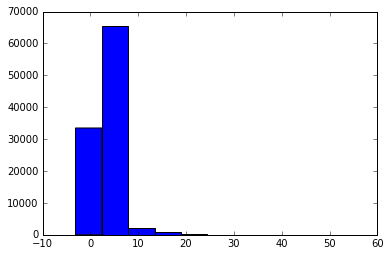

In [202]:
X = model.preprocess(data.X[0:10*10])
#plt.hist(get_out(X)[:, 0, :, :].flatten())
plt.hist(get_resid(X)[:, 0, :, :].flatten())

In [203]:
layers['brush'].assign_

{'color': (4, 7), 'gx': 0, 'gy': 1, 'x_stride': 2, 'y_stride': 3}

## Analyze

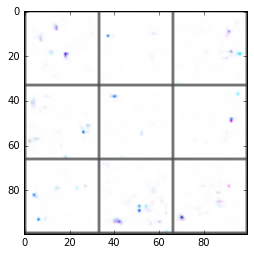

In [241]:
img = np.zeros((9,) + layers['raw_output'].output_shape[1:])
img += np.random.uniform(size=img.shape)
#img[:, 2, 0:2, :]=np.random.uniform
img = img.astype(np.float32)
img = disp_grid(1-sigmoid(get_out_from_raw_out(img)), border=1, bordercolor=(0.3,0.3,0.3))
plt.imshow(img)

array([[ 0.45171049,  0.56240213,  1.64197838,  0.80409235, -0.99817961,
        -2.23318076, -0.85155207],
       [-0.4101398 ,  0.56555569,  1.7770648 ,  0.85172141, -2.40607548,
        -3.27462053, -1.48317587],
       [-1.34979904,  0.74630708,  1.71376061,  0.65094405, -1.53290606,
        -1.50892973, -2.97236562],
       [-0.52979809, -0.57592511,  0.53883839,  0.75341356, -2.3511095 ,
        -2.55904579, -1.93516791],
       [ 0.03959758, -0.20594446,  0.7207728 ,  1.74932146, -1.54363644,
        -1.81327939, -1.23665226],
       [ 0.28429222, -0.39515105,  0.73118156,  2.09356523, -0.77208561,
        -2.93294978,  1.16167521],
       [ 0.52605557, -2.13150787,  0.35390523,  2.26644254, -0.51519841,
        -3.4298389 ,  0.1382371 ],
       [ 1.86470819, -2.18423319,  0.30704066,  2.51106048, -1.46706617,
        -3.60754967,  0.60596329],
       [ 2.09457445, -0.645531  , -0.15467529,  0.86328638, -1.2095809 ,
        -3.429914  ,  1.07087266],
       [ 1.42974782,  0.0358

In [253]:
def construct_seq(X):
    seq = []
    for t in range(layers['coord'].output_shape[1]):
        coord = get_repr(X)
        coord[:,t+1:]=-10
        img = draw(coord)
        seq.append(img)
    return seq

seq = construct_seq(X)
seq = np.array(seq)

In [259]:
seq = np.array(seq)
print(seq.shape)
seq = seq.transpose((1, 0, 2, 3, 4))

(20, 100, 3, 32, 32)


In [260]:
seq_to_video(seq, 'refined_seq.mp4')
embed_video('refined_seq.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoDomyPp/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/refined_seq.mp4


In [189]:
X = model.preprocess(data.X[0:10*10])

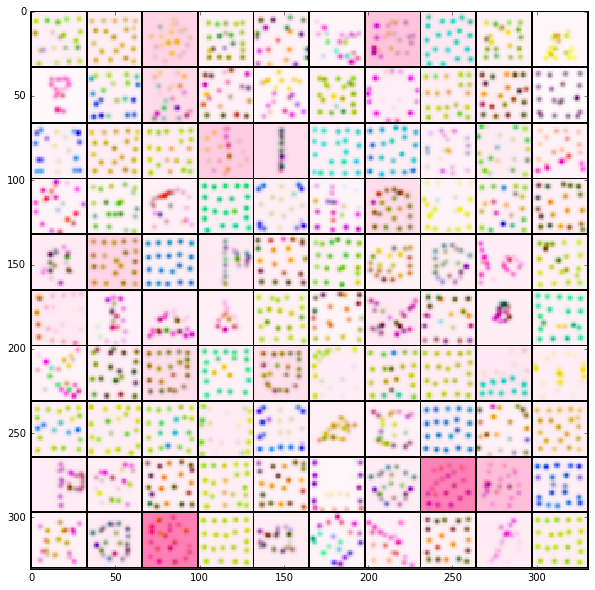

In [261]:
b = 1-get_out(X)
b = disp_grid(b, border=1, bordercolor=(0,0,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(b, interpolation='none')

In [299]:
layers['brush'].assign_

{'color': (4, 7), 'gx': 0, 'gy': 1, 'x_stride': 2, 'y_stride': 3}

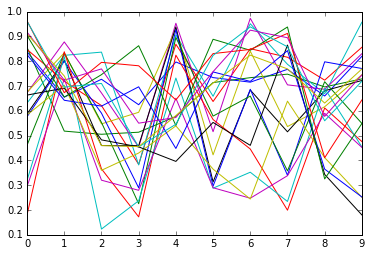

In [300]:
r = get_repr(X)
plt.plot(sigmoid(r[0:10, :, 2]))

(100, 20)


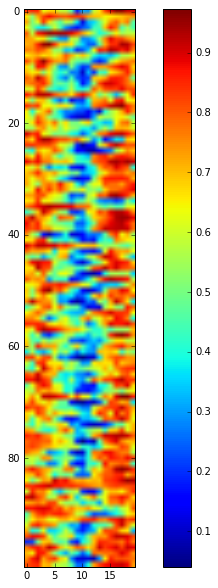

In [301]:
e = get_repr(X)
e = sigmoid(e[0:100,:,2])
print(e.shape)
fig = plt.figure(figsize=(10,10))
plt.imshow(e)
plt.colorbar()

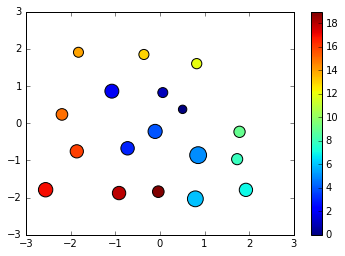

In [302]:
r = get_repr(X)[10, :, 0:4]
plt.scatter(r[:, 0], r[:, 1], c=np.arange(len(r)), s=100*np.maximum(r[:,2], r[:, 3]))
plt.colorbar()

## get coords from images

In [262]:
codes = []
for encoder in encoders:
    code = encoder(X)
    codes.append(code)
cols = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1)]
cols = cols + cols
pointers = []
for i, code in enumerate(codes):
    pointer = build_pointer_images(code, cols[i], w, h, p=1)
    pointers.append(pointer)
pointers = sum(pointers)
seq_to_video(pointers, 'pointers.mp4')
embed_video('pointers.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoFR6ygX/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoFR6ygX/img00000001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoFR6ygX/img00000002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoFR6ygX/img00000003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoFR6ygX/img00

ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/pointers.mp4


## video of gen

In [298]:
imgs = brush(X) # (examples, time, c, w, h)
imgs = sum(imgs)
imgs = accumulate(imgs, lambda a,b:a+b)
#imgs = imgs * scale + bias
imgs = 1-sigmoid(imgs)
#imgs = normalize(imgs, axis=(0,1))
#imgs = imgs #+ pointers * (1-imgs)
seq_to_video(imgs, 'seq.mp4')
embed_video('seq.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoSRTKrb/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/seq.mp4


AttributeError: 'Figure' object has no attribute 'axis'

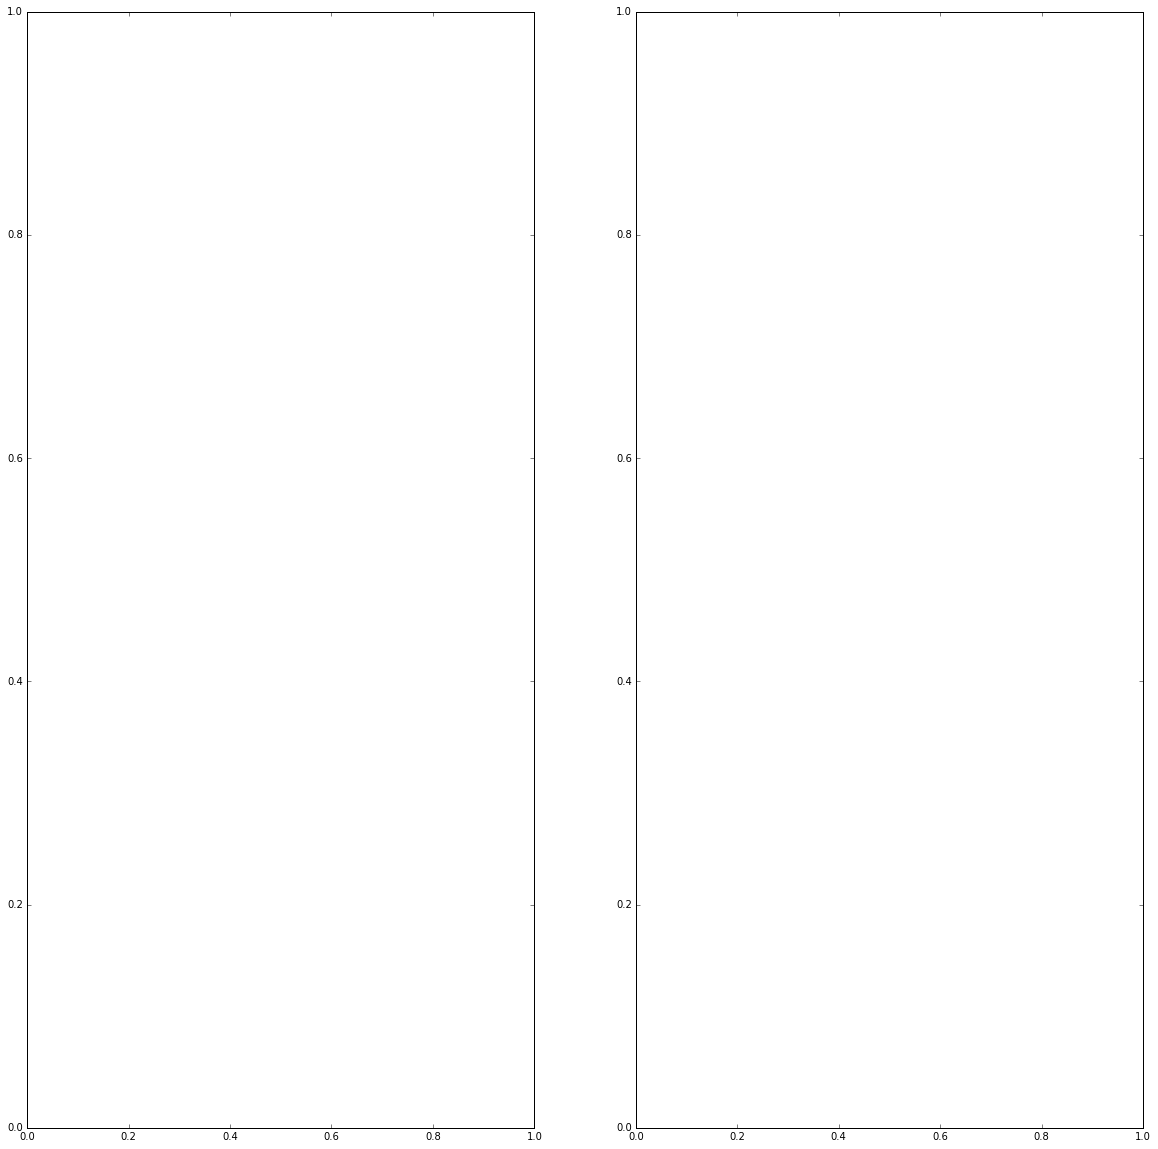

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
d = imgs[:,-1].copy()
d = disp_grid(d)
fig.axis('off')
ax1.imshow(d)
m = get_resid(X)
d = 1-sigmoid( ((get_resid(X)+get_out(X)))*0.5     ) 
d = normalize(d, axis=0)
d = disp_grid(d)
plt.axis('off')
ax2.imshow(d)

## Reconstruct

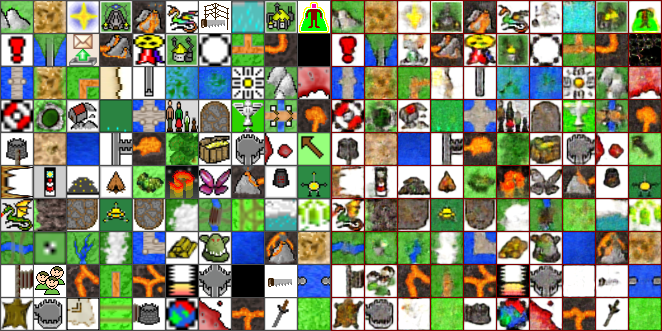

In [307]:
im1 = disp_grid(model.preprocess(data.X[0:100]), border=1, bordercolor=(.3, .3, .3))
im2 = disp_grid(reconstruct(model.preprocess(data.X[0:100])), border=1, bordercolor=(.5, 0, 0))
im_mix = np.empty(( max(im1.shape[0], im2.shape[0]), im1.shape[1] + im2.shape[1], 3))
im_mix[0:im1.shape[0], 0:im1.shape[1]] = im1
im_mix[0:im2.shape[0], im1.shape[1]:] = im2
imsave('im_mix.png', im_mix)
Image('im_mix.png', width=800, height=800)

## iterative refinement

In [111]:
np.random.seed(2)
nb_iter = 50
nb_examples = 9
thresh = None
use_noise = False
learning_rate = 0.1
c = layers['output'].output_shape[1]
# PREP
if thresh == 'moving':
    whitepx_ratio = (data.X>0.5).sum() / np.ones_like(data.X).sum()

imgs = np.empty((nb_examples, nb_iter + 1, c, w, h)) # 1 = color channel
imgs = imgs.astype(np.float32)
imgs[:, 0] = np.random.uniform(size=(nb_examples, c, w, h))

if use_noise: noise = np.random.normal(0, 0.01, size=imgs[:, 0].shape).astype(np.float32) #(for colored images)
else: noise = 0

scores = []
diversities = []

# ITERATIOn

for i in tqdm(range(1, nb_iter + 1)):
    
    #if use_noise:noise = np.random.normal(0, 0.001, size=imgs[:, 0].shape).astype(np.float32) #(for colored images)
    #else:noise = 0
    
    new = model.reconstruct(imgs[:, i - 1] + noise)
    prev = imgs[:, i - 1] 
    imgs[:, i] = new * learning_rate + prev * (1-learning_rate)
    if c == 1:
        if thresh == 'moving':
            vals = imgs[:, i].flatten()
            vals = vals[np.argsort(vals)]
            thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
        else:
            thresh_ = thresh
        if thresh_:
            imgs[:, i] = imgs[:, i] > thresh_ # binarize
    score = np.abs(imgs[:, i - 1] - imgs[:, i]).sum()
    scores.append(score)
    diversity = prop_uniques(imgs[:, i])
    diversities.append(diversity)

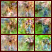

In [112]:
fig = plt.figure(figsize=(10, 10))
img = disp_grid(imgs[:, -1], border=1, bordercolor=(0.3, 0, 0))
imsave('ir.png', img)
Image('ir.png', width=500, height=500)

In [113]:
seq_to_video(imgs, 'ir.mp4', border=0, bordercolor=(0, 0, 0))
embed_video('ir.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_videoeXvXOH/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/ir.mp4


In [ ]:
plt.title('Score')
plt.plot(np.log(np.array(scores)) / np.log(10))
plt.show()
plt.title('Diversity')
plt.plot(diversities)
plt.show()

## Feeding a new image

In [79]:
#dt_test = load_data('strokes', w=w,h=h) # for grayscale
#dt_test = load_data('digits', w=w, h=h)
dt_test = load_data('omniglot', w=w, h=h)

(128, 16, 16)
((128, 16, 16), 16, 16, 1)


(100, 3, 16, 16)
0.0698142


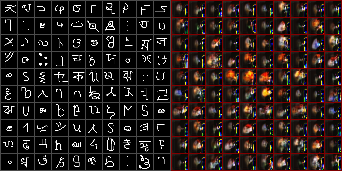

In [114]:
# load from file

nb = 100
dt = dt_test.X[0:nb]
try:
    dt = dt.reshape((nb, c, w, h))
except Exception:
    dt = dt.reshape((nb, 1, w, h))
    dt = dt * np.ones((1, 3, 1, 1))
    dt = dt.astype(np.float32)
print(dt.shape)
rec = reconstruct(dt)
print(((rec - dt)**2).mean())

im1 = disp_grid(model.preprocess(dt[0:nb]), border=1, bordercolor=(.3, .3, .3))
im2 = disp_grid(reconstruct(model.preprocess(rec[0:nb])), border=1, bordercolor=(.5, 0, 0))
im_mix = np.empty((im1.shape[0], im1.shape[1] + im2.shape[1], 3))
im_mix[:, 0:im1.shape[1]] = im1
im_mix[:, im1.shape[1]:] = im2
imsave('im_mix_new_dataset.png', im_mix)
Image('im_mix_new_dataset.png', width=800, height=800)

## interpolation

In [ ]:
print(layers.keys())

In [81]:
lay = ['fc1_net{}'.format(i) for i in range(nb_parallel)]
lay = tuple(lay)
if lay[0] not in layers:
    lay = ('coord')
tensors = tuple(T.tensor3() for _ in range(nb_parallel))
#tensors = tuple(T.matrix() for _ in range(nb_parallel))

img2code = build_image_to_code_func(layers, lay=lay)
code2img = build_code_to_image(layers, lay=lay, X=tensors)

In [82]:
indices = np.random.randint(0, len(data.X), size=4)
codes = img2code(model.preprocess(data.X[indices]))
shapes = [c.shape[1:] for c in codes]
codes_flat = [c.reshape(c.shape[0], -1) for c in codes]
sizes = [c.shape[1] for c in codes_flat]
codes_concat = np.concatenate(codes_flat, axis=1)

z_dim = codes_concat.shape[1:]
D = 10
alpha = np.linspace(0, 1, D)
beta = np.linspace(0, 1, D)
grid_codes = np.empty((D*D,) + z_dim, dtype='float32')
k = 0
for a in alpha:
    for b in beta:
        grid_codes[k] = a*b*codes_concat[0] + a*(1-b)*codes_concat[1] + (1-a)*b*codes_concat[2]  + (1-a)*(1-b)*codes_concat[3]
        k +=1

i = 0
orig_codes = []
for s in sizes:
    orig_codes.append(grid_codes[:, i:i+s])
    i+=s
orig_codes = [orig_code.reshape((orig_code.shape[0],) + shape) for orig_code, shape in zip(orig_codes, shapes)]
print(orig_codes[0].shape)
grid_imgs = code2img(*orig_codes)

(100, 20, 7)


In [ ]:
imsave('grid.png', disp_grid(grid_imgs, border=2, bordercolor=(0.3,0.,0.)))
Image('grid.png', width=500, height=500)

## painting

In [ ]:
from skimage.io import imread

In [ ]:
img = imread('fd1-lngchr-rd_field-lounge-chair-craig-red_2.jpg')
img = img[200:-200, 200:-200]
img = img / 255.
img = img.astype(np.float32)
plt.imshow(img)
img = img.transpose((2, 0, 1))
img = img[np.newaxis, :, :, :]
print(img.shape)
img_orig = img.copy()

In [ ]:
#img = np.random.uniform(size=(1, 3, 100,100))
#img = np.zeros_like(img)
img = img.astype(np.float32)
lr=0.1
for _ in range(1000):
    y = np.random.randint(0, img.shape[2] - h)
    x = np.random.randint(0, img.shape[3] - w)
    new = model.reconstruct(img[:, :, y:y+h, x:x+w])
    old = img[:, :, y:y+h, x:x+w]
    img[:, :, y:y+h, x:x+h] = new*lr+old*(1-lr)

In [ ]:
plt.imshow(img[0].transpose((1, 2, 0)))